# OLG model
I assume the market completeness.
In this code, I don't consider
- individual uncertainty 
- life-time uncertainty 
- transitional dynamics

In [1]:
using BenchmarkTools
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
mutable struct Model
    # primitive parameter
    beta::Float64 #subjective discount factor
    sigma::Float64 # relative risk aversion
    gamma::Float64 # weight on comsumption
    delta::Float64 #depriciation rate
    alpha::Float64 # capital share
    n::Float64 # pop growth
    tau::Float64 # ss tax

    # discretize asset space
    agrid::Array{Float64,1}
    # age productivity
    e::Array{Float64,1}
end


function OLG(m::Model)
    # preference
    const beta = m.beta
    const sigma = m.sigma 
    const gamma = m.gamma
    # production
    const alpha = m.alpha
    const delta = m.delta
    # demog
    const J = 66
    const JR = 46
    const tR = J-JR+1
    const tW = JR-1
    const n = m.n
    
    #ss 
    const tau = m.tau
    
    # measure
    mass::Array{Float64,1} = ones(J)
    for ik0 in 2:J
        @inbounds mass[ik0]=mass[ik0-1]/(1.0+n)
    end
    # normalize
    mass = mass/sum(mass)
      
    #age efficiency
    const e = m.e
    # create asset grid
    const agrid = m.agrid
    const na = size(agrid,1)
    #penalty for negative consumption
    const neg::Float64 = -1e10
    
    # initial guess
    K0 = 3.0
    L0 = 0.34
    
    
    v::Array{Float64,2} = zeros(na,J)
    pol_a::Array{Float64,2} = zeros(na,J)
    pol_lab::Array{Float64,2} = zeros(na,tW)
    a_index::Array{Int64,2} = ones(na,J)
    
    kgen::Array{Float64,1} = zeros(J)
    labgen::Array{Float64,1} = zeros(tW)
    
    # iteration set-up
    iter::Int64 = 0
    const maxiter = 100
    const tolk = 1e-3
    const tollab = 1e-3
    err_k = 10.0
    err_lab = 10.0
    
    # compute equilibrium
    while err_k> tolk || err_lab > tollab
        
        # factor price
        r0 = alpha*(K0^(alpha-1.0))*(L0^(1.0-alpha)) -delta
        w0 = (1.0-alpha)*(K0^(alpha))*(L0^(-alpha))
        
        #pension
        b = tau*w0*L0/(sum(@views mass[JR:end]))
    
        # backward induction
        
        
        # retired households
        
        # last period utility
        for ia0 in 1:na
            cons = (1.0+r0)*agrid[ia0] + b
            @inbounds v[ia0,J] = (cons^(1.0-sigma))/(1.0-sigma)
        end

        for j in J-1:-1:tW+1
            gridstart::Int64=1
            for ia0 in 1: na
                vmin = neg 
                for ia1 in gridstart:na
                    cons =(1.0+r0)*agrid[ia0] +b - agrid[ia1]
                    if cons<= 0.0
                        util = neg        
                    else
                        util = (cons^(1.0-sigma))/(1.0-sigma)
                    end
                    v0 = util + beta* v[ia1,j+1]
                    
                    if v0 > vmin
                        @inbounds v[ia0,j] = copy(v0)
                        @inbounds a_index[ia0,j] =ia1
                        gridstart = copy(ia1)
                        vmin = copy(v0)
                    end
                end
            end
        end
        
        # working household
        for j in tW:-1:1
            gridstart::Int64 =1
            for ia0 in 1 : na
                vmin = neg
                for ia1 in gridstart: na
                    lab =(gamma*(1.0-tau)*e[j]*w0-(1.0-gamma)*((1.0+r0)*agrid[ia0]-agrid[ia1]))/((1.0-tau)*e[j]*w0)
                    
                    # fesibility
                    if lab <0.0
                        lab = 0.0
                    elseif lab > 1.0
                        lab = 1.0
                    end
                    
                    cons =(1.0+r0)*agrid[ia0] + (1.0-tau)*w0*e[j]*lab - agrid[ia1]
                    
                    if cons<0.0
                        util =neg
                    else
                        util =(((cons^gamma)*(1.0-lab)^(1.0-gamma))^(1.0-sigma))/(1.0-sigma)
                    end
                    
                    @inbounds v0 = util + beta*v[ia1,j+1]
                    if v0 > vmin
                        @inbounds v[ia0,j] = v0
                        @inbounds a_index[ia0,j] = ia1
                        @inbounds pol_lab[ia0,j] = lab
                        gridstart= ia1
                        vmin = copy(v0)
                    end
                end
            end
        end
        # calculate asset holdings and labor supply for each generation
        ia0 = 1
        for j in 1:J
            
            ia1 = a_index[ia0,j]
            @inbounds kgen[j] = agrid[ia1]
            if j <= tW
                @inbounds labgen[j] = @views pol_lab[ia0,j]*@views e[j]
            end
            ia0 = ia1
            
        end
        
        for j in 1:J
            for ia0 in 1:na
                @inbounds pol_a[ia0,j] = agrid[@views a_index[ia0,j]]
            end
        end
        
        # aggregation
        K1 = dot(kgen,mass)
        L1 = dot(labgen, @views mass[1:tW])
        
        # update initial guess
        K0 = 0.5*K0 + 0.5*K1
        L0 = 0.5*L0 + 0.5*L1
        
        # update error 
        err_k =abs(K0-K1)
        err_lab = abs(L0-L1)
        iter += 1
        if iter > maxiter
            println("the model cannot converge in $maxiter times iteration")
            break
        end
    end
    return(K0, L0,pol_a,pol_lab, v, agrid)
end                    

OLG (generic function with 1 method)

In [3]:
# preference
beta = 0.97
sigma = 2.0
gamma = 0.42
# production
alpha = 0.36
delta = 0.06
#popgrowth
n = 0.011
#ss tax    
tau = 0.11
# create asset grid
amax = 14.0
amin = 0.01
na = 180
agrid = linspace(amin,amax,na)
# age efficiency
e = zeros(45)
@views e[1:11]  = linspace(0.6, 1.0, 11)
@views e[11:21] = linspace(1.0, 1.08, 11)
@views e[21:31] = linspace(1.08, 1.12, 11)
@views e[31:41] = linspace(1.12, 1.06, 11)
@views e[41:45] = linspace(1.06, 1.02, 5)

model = Model(beta, sigma, gamma, delta, alpha, n, tau, agrid, e)

Model(0.97, 2.0, 0.42, 0.06, 0.36, 0.011, 0.11, [0.01, 0.0881564, 0.166313, 0.244469, 0.322626, 0.400782, 0.478939, 0.557095, 0.635251, 0.713408  …  13.2966, 13.3747, 13.4529, 13.5311, 13.6092, 13.6874, 13.7655, 13.8437, 13.9218, 14.0], [0.6, 0.64, 0.68, 0.72, 0.76, 0.8, 0.84, 0.88, 0.92, 0.96  …  1.09, 1.084, 1.078, 1.072, 1.066, 1.06, 1.05, 1.04, 1.03, 1.02])

In [4]:
K,L,pol_a,pol_lab,v0,agrid =OLG(model)

(2.9824058243855243, 0.34998246653616494, [0.01 0.01 … 0.01 0.01; 0.01 0.01 … 0.01 0.01; … ; 13.7655 13.7655 … 7.04408 0.01; 13.8437 13.8437 … 7.12223 0.01], [0.419754 0.419769 … 0.777081 0.816654; 0.356509 0.360477 … 0.775961 0.815524; … ; 0.0 0.0 … 0.22057 0.218615; 0.0 0.0 … 0.219451 0.217485], [-54.6035 -53.9822 … -8.81661 -4.37388; -54.3832 -53.78 … -7.58451 -3.23378; … ; -36.7585 -36.4793 … -0.262384 -0.0686036; -36.6923 -36.4138 … -0.260959 -0.0682263], [0.01, 0.0881564, 0.166313, 0.244469, 0.322626, 0.400782, 0.478939, 0.557095, 0.635251, 0.713408  …  13.2966, 13.3747, 13.4529, 13.5311, 13.6092, 13.6874, 13.7655, 13.8437, 13.9218, 14.0])

In [5]:
@time OLG(model)

  0.158313 seconds (108 allocations: 443.842 KiB)


(2.9824058243855243, 0.34998246653616494, [0.01 0.01 … 0.01 0.01; 0.01 0.01 … 0.01 0.01; … ; 13.7655 13.7655 … 7.04408 0.01; 13.8437 13.8437 … 7.12223 0.01], [0.419754 0.419769 … 0.777081 0.816654; 0.356509 0.360477 … 0.775961 0.815524; … ; 0.0 0.0 … 0.22057 0.218615; 0.0 0.0 … 0.219451 0.217485], [-54.6035 -53.9822 … -8.81661 -4.37388; -54.3832 -53.78 … -7.58451 -3.23378; … ; -36.7585 -36.4793 … -0.262384 -0.0686036; -36.6923 -36.4138 … -0.260959 -0.0682263], [0.01, 0.0881564, 0.166313, 0.244469, 0.322626, 0.400782, 0.478939, 0.557095, 0.635251, 0.713408  …  13.2966, 13.3747, 13.4529, 13.5311, 13.6092, 13.6874, 13.7655, 13.8437, 13.9218, 14.0])


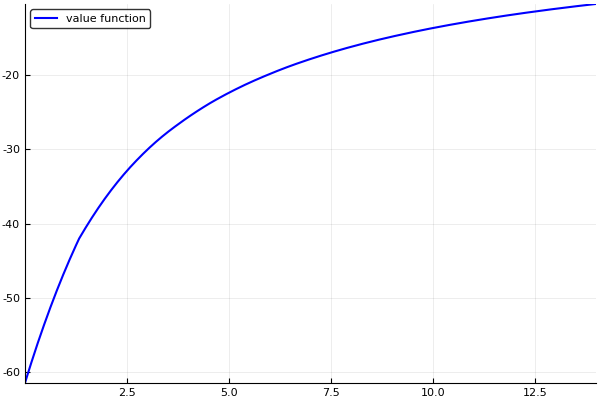

In [6]:
plot(agrid,v0[:,50], color ="blue", linewidth=1.5,label="value function")


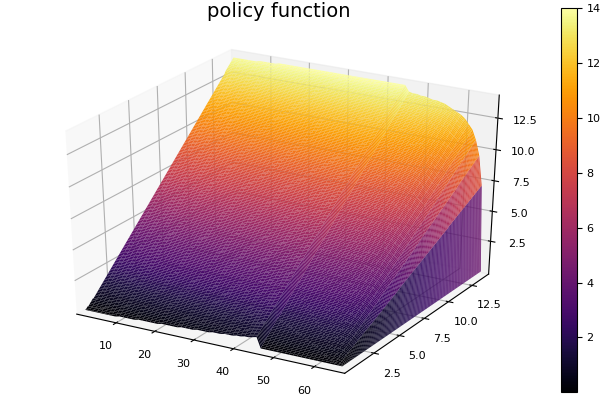

In [7]:
age = 1 : 66
Plots.surface(age,agrid,pol_a, title="policy function")

In [8]:
@benchmark OLG(model)

BenchmarkTools.Trial: 
  memory estimate:  437.75 KiB
  allocs estimate:  25
  --------------
  minimum time:     154.170 ms (0.00% GC)
  median time:      158.803 ms (0.00% GC)
  mean time:        161.462 ms (0.00% GC)
  maximum time:     205.894 ms (0.00% GC)
  --------------
  samples:          31
  evals/sample:     1

In [9]:
@profile OLG(model)
Profile.print()

59 .\task.jl:335; (::IJulia.##14#17)()
 59 ...IJulia\src\eventloop.jl:8; eventloop(::ZMQ.Socket)
  59 ...rc\execute_request.jl:154; execute_request(::ZMQ.Socket, ::I...
   59 ...\Compat\src\Compat.jl:174; include_string(::Module, ::Strin...
    59 .\loading.jl:522; include_string(::String, ::String)
     58 .\<missing>:?; anonymous
      58 .\profile.jl:23; macro expansion
       1  .\In[2]:103; OLG(::Model)
        1 .\math.jl:699; ^
       1  .\In[2]:107; OLG(::Model)
       4  .\In[2]:123; OLG(::Model)
       2  .\In[2]:128; OLG(::Model)
       1  .\In[2]:134; OLG(::Model)
       48 .\In[2]:137; OLG(::Model)
        48 .\math.jl:699; ^
         1 .\math.jl:300; nan_dom_err
       1  .\In[2]:140; OLG(::Model)
     1  .\inference.jl:2622; typeinf_ext(::Core.MethodInsta...
      1 .\inference.jl:2583; typeinf_code(::Core.MethodInst...
       1 .\inference.jl:2504; typeinf_frame(::Core.MethodIns...
        1 .\inference.jl:2787; typeinf(::Core.Inference.Infe...
         1 .\inference.jl

In [10]:
@code_warntype OLG(model)

Variables:
  #self# <optimized out>
  m::Model
  ik0::Int64
  #temp#@_4::Int64
  cons@_5::Float64
  #temp#@_6::Int64
  ia1@_7::Int64
  util@_8::Float64
  v0@_9::Float64
  cons@_10::Float64
  #temp#@_11::Int64
  vmin@_12::Float64
  #temp#@_13::Int64
  j@_14::Int64
  gridstart@_15::Int64
  #temp#@_16::Int64
  lab::Float64
  ia1@_18::Int64
  cons@_19::Float64
  util@_20::Float64
  v0@_21::Float64
  #temp#@_22::Int64
  vmin@_23::Float64
  #temp#@_24::Int64
  j@_25::Int64
  gridstart@_26::Int64
  #temp#@_27::Int64
  j@_28::Int64
  ia1@_29::Int64
  #temp#@_30::Int64
  #temp#@_31::Int64
  j@_32::Int64
  #temp#@_33::Int64
  r0::Float64
  w0::Float64
  b::Float64
  ia0::Int64
  K1::Float64
  L1::Float64
  beta::Float64
  sigma::Float64
  gamma::Float64
  alpha::Float64
  delta::Float64
  J@_45 <optimized out>
  JR <optimized out>
  tR <optimized out>
  tW::Int64
  n::Float64
  tau::Float64
  e::Array{Float64,1}
  agrid::Array{Float64,1}
  na::Int64
  neg <optimized out>
  maxiter <optimized out

      SSAValue(95) = (Base.select_value)((Base.slt_int)(SSAValue(94), 0)::Bool, 0, SSAValue(94))::Int64
      # meta: location subarray.jl maybeview 469
      $(Expr(:inbounds, false))
      # meta: location subarray.jl view 112
      # meta: location indices.jl to_indices 213
      # meta: location abstractarray.jl indices 64
      (Base.arraysize)(mass::Array{Float64,1}, 1)::Int64
      # meta: pop location
      # meta: pop location
      SSAValue(115) = $(Expr(:new, UnitRange{Int64}, 46, :((Base.select_value)((Base.sle_int)(46, SSAValue(95))::Bool, SSAValue(95), (Base.sub_int)(46, 1)::Int64)::Int64))) # line 113:
      SSAValue(99) = (Core.tuple)(SSAValue(115))::Tuple{UnitRange{Int64}}
      # meta: location abstractarray.jl checkbounds 362
      SSAValue(101) = (Core.getfield)(SSAValue(99), 1)::UnitRange{Int64}
      # meta: location abstractarray.jl checkbounds 347
      # meta: location abstractarray.jl linearindices 99
      # meta: location abstractarray.jl indices1 71
      #

      gridstart@_15::Int64 = ia1@_7::Int64 # line 111:
      vmin@_12::Float64 = v0@_9::Float64
      405: 
      goto 355
      407: 
      goto 343
      409: 
      goto 332
      411:  # line 118:
      $(Expr(:inbounds, false))
      # meta: location range.jl colon 30
      # meta: location range.jl _colon 32
      # meta: location range.jl Type 145
      # meta: location range.jl Type 93
      SSAValue(129) = $(Expr(:invoke, MethodInstance for steprange_last(::Int64, ::Int64, ::Int64), :(Base.steprange_last), :(tW), -1, 1))
      # meta: pop location
      # meta: pop location
      # meta: pop location
      # meta: pop location
      $(Expr(:inbounds, :pop))
      SSAValue(195) = tW::Int64
      #temp#@_27::Int64 = SSAValue(195)
      426: 
      unless (Base.not_int)((Base.or_int)((Base.and_int)((Base.not_int)((SSAValue(195) === SSAValue(129))::Bool)::Bool, (Base.not_int)(((Base.slt_int)(0, -1)::Bool === (Base.slt_int)(SSAValue(195), SSAValue(129))::Bool)::Bool)::Bool)::Bool, 

      K0::Float64 = (Base.add_float)((Base.mul_float)(0.5, K0::Float64)::Float64, (Base.mul_float)(0.5, K1::Float64)::Float64)::Float64 # line 176:
      L0::Float64 = (Base.add_float)((Base.mul_float)(0.5, L0::Float64)::Float64, (Base.mul_float)(0.5, L1::Float64)::Float64)::Float64 # line 179:
      err_k::Float64 = (Base.abs_float)((Base.sub_float)(K0::Float64, K1::Float64)::Float64)::Float64 # line 180:
      err_lab::Float64 = (Base.abs_float)((Base.sub_float)(L0::Float64, L1::Float64)::Float64)::Float64 # line 181:
      SSAValue(39) = (Base.add_int)(iter::Int64, 1)::Int64
      iter::Int64 = SSAValue(39) # line 182:
      unless (Base.slt_int)(100, iter::Int64)::Bool goto 713 # line 183:
      $(Expr(:inbounds, false))
      # meta: location strings/io.jl string 120
      SSAValue(170) = "the model cannot converge in "
      SSAValue(171) = 100
      SSAValue(172) = " times iteration"
      # meta: pop location
      $(Expr(:inbounds, :pop))
      SSAValue(218) = $(Expr(:invoke, 